# Retention rates for US Universities

This project is being built from the ground up to be customizable and reproducible.

After importing the libraries we need, we're going to load up a table of instructions containing which
of the several thousand attributes we're going to select from the IPEDS database for data mining. This is a lot, so it seems more reasonable to externally store the data list we'll be drawing from.

Many of these, such as website addresses or mission statements, aren't going to be terribly useful. Some others we'll need to exclude as it is too closely related to retention rate, and we risk overfitting or circular logic ("hey, here's how to raise your retention rate--have more of them graduate!")

At the root, each entry in the JSON file denotes a separate table. Included alongside the table name are instructions on whether all the table should be imported as default or not, which attributes are continuous, which are discrete, and  which are strings, and whether multiple records exist for each primary key. This is all derived from the associated documentation that comes with IPEDS. 

We're going to load in each table (obviously checking that it doesn't exist first), and extract the correct tables from it. 

(Should you want to change what we're measuring, you can change the response variable within the JSON file.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from IPython.display import display, Markdown, Latex
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
import pickle
import scipy
import json
import wget
import sys
import re
import os
from zipfile import ZipFile as zf

# Function to search over list of lists. If the entry exists in the list,
# return the index of which list it's in, otherwise, return False.

def searchlist(tosearch, entry):
    for r in enumerate(tosearch):
        if entry in r[1]:
            return r[0]
    return False


Below, we're going to set some variables for how (and where) we process the data.

* *MAXIMUM_NAN* : the ratio of NaNs at which we remove the column entirely.
* *MAXIMUM_COR* : the maximum Pearson correlation that a column can have with another before it's removed.
* *MINIMUM_VAR* : the minimum variance needed in an attribute
* *SAMPLE_SIZE* : the fraction of the final dataset to use to build the forest
* *DATA_PATH* : where the data is stored.
* *RANDOM_SEEDS* : a list of random seeds to use for creating the forest
* *MODELS*: a list of four tuples containing the models we can cycle through, along with the parameters they need
* *REMOVE_OUTLIERS*: whether to remove all values of the response variable that are 100% or 0%
* *SLICES*: a list of ways to slice the data. there will be one forest/tree chosen to explain each slice. There are on ICLEVEL (which is 4 year, 2-4 year, and <=2 year) and CONTROL (public, private not-for-profit, private for-profit).

In [2]:
MAXIMUM_NAN = 0.80
MAXIMUM_COR = 0.85
MINIMUM_VAR = 0.5
SAMPLE_SIZE = 0.90
DATA_PATH = "data"
RANDOM_SEEDS = [15, 125, 1125, 1250, 1500, 1555, 13125]
MODELS = [(LinearRegression, {}),
          (ExtraTreesRegressor, {"random_state":0, "n_estimators":100, "n_jobs":-1}),
          (RandomForestRegressor, {"random_state":0, "n_estimators":100, "n_jobs":-1}),
          (GradientBoostingRegressor, {"random_state":0, "n_estimators":100})]

# the random seed will be fed in later at runtime.
# there's no random state on the linear regression itself (other than the sampling)

REMOVE_OUTLIERS = False
SLICES = [("Institutions: Four or more years", ["ICLEVEL", 1]),
          ("Institutions: At least 2 but less than 4 years", ["ICLEVEL", 2]),
          ("Institutions: Less than 2 years (below associate)", ["ICLEVEL", 3]),
          ("Public institutions", ["CONTROL", 1]),
          ("Private not-for-profit institutions", ["CONTROL", 2]),
          ("Private for-profit", ["CONTROL", 3]),
          ("All institutions", [])]

### Step 1: Reading in and cleaning the IPEDS and ACS data

Next come the functions for reading in the data from files/ZIP archives, corraling them all to one row per unique key, and making sure they're the right data type.

In [3]:
def convert(tdf, columnlist, totype):

# this changes the datatype in each column. where columns have been unstacked, this is supposed
# to change all instances of each unstacked column to that datatype

    for col in columnlist:
        r = re.compile("(^"+col+"*)|(_"+col+")")
        # column name must either be first or have a _ before it, depending on whether we're
        # putting the table names next to it to make it unique
        for c in filter(r.match, list(tdf)): # filter all the column names through this regex
            tdf[c] = tdf[c].astype(totype)

def import_data(filename):
    with open(filename) as file:
        instructions = json.load(file)
        
# does the data directory exist? if no, create it.
    
    if os.path.isdir(DATA_PATH) is False:
        try:  
            os.mkdir(DATA_PATH)
        except OSError:  
            print ("Could not create data folder.")
            raise
            
# start with an empty dataframe to fill, and get the primary key.
# the primary key should be in the first file in the data list
# also figure out if we are adding the tablename to the attributes to make them unique

    ourdata = pd.DataFrame()
    pk = instructions["primarykey"]
    unique_headers = instructions["uniqueheaders"]

# loop through each table. 

    for table in instructions["tables"]:
        
# first, check if the file in the table has been downloaded. if not, download it from
# the path given and throw an error if something is wrong.

        filename = table["name"]+instructions["format"]
        filelocation = DATA_PATH+"/"+filename
        csvfile = DATA_PATH+"/"+table["name"]+".csv"

        if instructions["lowercase"]:
            csvfile = str(csvfile).lower()

        if os.path.exists(filelocation) is False:
            try:
                wget.download(instructions["url"]+filename, filelocation)
            except Exception as e:
                print("Problem downloading and saving", table["name"], ":", e)
                raise

# next, if they are zip files, unzip them

        if instructions["format"] == ".zip":
            if os.path.exists(csvfile) is False:
                print("Unzipping "+table["name"])
                with zf(filelocation,"r") as zip_ref:
                    zip_ref.extractall(DATA_PATH)

# load each CSV file into a temporary data frame, tdf

        if "skiprows" in instructions:
            tdf = pd.read_csv(str(csvfile), encoding = "ISO-8859-1",
                              skiprows = lambda x: x in instructions["skiprows"],
                              low_memory = False)
        else:
            tdf = pd.read_csv(str(csvfile), encoding = "ISO-8859-1", low_memory = False)

# filter the data according to any values needed

        if "filter" in table:
            for filterinfo in table["filter"]:
                tdf = tdf.loc[tdf[filterinfo[0]] == filterinfo[1]]

# then, depending on the instructions in the JSON file, include all the headers, or include a selection.

        if table["includeall"]:

# include the whole list, excluding the specific tables (might be an empty list)
# and add the primary key to select

            to_include = list(tdf)
            to_exclude = table["exclude"]
            headers = [x for x in to_include if x not in to_exclude]
            headers.append(pk)

# otherwise, stick these three lists together plus the primary key

        else:
            headers = [pk, *table["strings"], *table["discrete"], *table["continuous"]]

        selected_headers = [x for x in tdf.columns if x in headers]

# columns that begin with an X should be removed, at least for now, because they don't describe
# anything other than how the data was collected
# we should also remove any Margin of Error data (_MOE_), it's not needed

        selected_headers = [x for x in selected_headers if not re.search("(?:_MOE_)|(?:^X\s*)", x)]

        # ok, so do we have a primary key? if not, stop right there

        if pk not in tdf.columns:
            raise KeyError("Primary key "+pk+" not found in "+table["name"])

# now we can select the headers we want.

        tdf = tdf[selected_headers]
    
# the code below adds the table name to the headers now, to prevent issues with duplication
# to everythng other than the key

        if unique_headers:
            tdf.rename(columns = lambda x: pk if x == pk else table["name"]+"_"+x, inplace = True)

# next we must check in the JSON instructions if this table contains multiple rows for each
# unique ID. if so, we need to put them all on the same row. to do this, we change them to strings
# then read them into a multiple index, unstack, and then join the column names.

        if "multi" in table:

            if unique_headers:
                multi = [table["name"]+"_"+x for x in table["multi"]]
            else:
                multi = table["multi"]
            tdf[multi] = tdf[multi].astype(str)
            tdf = tdf.set_index([pk, *multi])
            tdf = tdf.unstack(multi)               # need to specify ALL the levels
            tdf.columns = ['_'.join(col) for col in tdf.columns.values]
            tdf = tdf.reset_index(level=pk)

# any '.', '. ', '(X)', '****'', '-' data should be NaN

        tdf = tdf.replace(r"(^\. ?$)|(^\(X\)$)|(^N$)|(^\*{2,}$)|(^-$)", np.nan, regex=True)

# also, apparently some of the ACS data has '-' and '+' signs at the end of some estimates.
# this is not too helpful if we're casting to float, so we'll remove them.

        tdf = tdf.replace(r"(\+$)|(\-$)", "", regex=True)

# and, for some reason, actual commas in numerals. replace them in numbers only, though.

        tdf = tdf.replace(r"(\d+)(,)(\d+)", r"\1\3", regex=True)

# one important thing to do here is to set the right data types--strings or discrete data.
# most of the data in IPEDS and ACS are continuous, but there are a couple of strings and a 
# handful of discrete data.

        if "defaulttype" in table:
            tdfheds = list(tdf) # get list of headers
            hedstoremove = [pk, *table["strings"], *table["discrete"], *table["continuous"]]
            tdfheds = [x for x in tdfheds if x not in hedstoremove]
            if table["defaulttype"] == "discrete":
                convert(tdf, tdfheds, "category")  
            elif table["defaulttype"] == "string":
                convert(tdf, tdfheds, "str")
            else:
                convert(tdf, tdfheds, "float")
                # only way to store NaNs

        convert(tdf, table["strings"], "str")
        convert(tdf, table["discrete"], "category")
        convert(tdf, table["continuous"], "float")
        
        if pk in tdf:
            tdf[pk] = tdf[pk].astype('str') # it is in the index if the data is unstacked

# if it's the first time around the loop, take the first set of data.

        if ourdata.empty:
            ourdata = tdf

# if not, then we need to join on the primary key

        else:
            ourdata = ourdata.merge(tdf,on=pk,how="left")

        print ("Imported "+ table["name"]+ ": "+str(len(ourdata.columns))+" columns total, "
              + str(round(float(ourdata.memory_usage().sum() / 1048576), 2)) + "MB")
        
    if "responsevar" in instructions:
        return ourdata, instructions["responsevar"]
    else:
        return ourdata, None

ipeds, responsevar = import_data("ipeds-instructions.json")

Imported HD2016: 27 columns total, 0.4MB
Imported IC2016: 132 columns total, 1.67MB
Imported IC2016_AY: 252 columns total, 8.56MB
Imported ADM2016: 290 columns total, 10.74MB
Imported EFFY2016: 380 columns total, 15.91MB
Imported EF2016A: 650 columns total, 31.4MB
Imported EF2016B: 776 columns total, 38.63MB
Imported EF2016C: 906 columns total, 46.09MB
Imported EF2016D: 917 columns total, 46.72MB
Imported EF2016A_DIST: 962 columns total, 49.3MB
Imported SFA1516: 1285 columns total, 67.83MB
Imported SFAV1516: 1303 columns total, 68.87MB
Imported F1516_F1A: 1413 columns total, 75.13MB
Imported F1516_F2: 1553 columns total, 83.11MB
Imported F1516_F3: 1632 columns total, 87.53MB
Imported EAP2016: 3990 columns total, 222.84MB
Imported SAL2016_IS: 4123 columns total, 230.47MB
Imported SAL2016_NIS: 4151 columns total, 232.08MB
Imported S2016_OC: 4833 columns total, 271.21MB
Imported S2016_SIS: 4910 columns total, 275.63MB
Imported S2016_NH: 4941 columns total, 277.41MB
Imported AL2016: 4971 c

Next, let's import the ACS data. This is 2016 5-year data, put together on a county level by the
American Fact Finder, with some exceptions (1-year data was only available for levels of Internet subscription.) Unfortunately, this data had to be generated and wasn't available for download.
In order to make this reproducible, I've uploaded the generated files to GitHub.

This data contains info, county-by-county, on employment, healthcare, commuting, income, and even things like how many computers each household has.

In [4]:
acs, x = import_data("acs5yr-instructions.json")

Imported ACS_16_5YR_S0101_with_ann: 109 columns total, 2.68MB
Imported ACS_16_5YR_S0701_with_ann: 389 columns total, 9.58MB
Imported ACS_16_5YR_S0801_with_ann: 560 columns total, 13.78MB
Imported ACS_16_5YR_S1101_with_ann: 660 columns total, 16.24MB
Imported ACS_16_5YR_S1701_with_ann: 843 columns total, 20.73MB
Imported ACS_16_5YR_S1810_with_ann: 1050 columns total, 25.82MB
Imported ACS_16_5YR_S2201_with_ann: 1278 columns total, 31.42MB
Imported ACS_16_5YR_S2301_with_ann: 1418 columns total, 34.86MB
Imported ACS_16_5YR_S2405_with_ann: 1508 columns total, 37.07MB
Imported ACS_16_1YR_S2701_with_ann: 1818 columns total, 44.69MB
Imported ACS_16_5YR_S2702_with_ann: 2028 columns total, 49.85MB
Imported ACS_16_1YR_S2801_with_ann: 2090 columns total, 51.37MB
Imported ACS_16_1YR_S2802_with_ann: 2244 columns total, 55.15MB
Imported ACS_16_5YR_B01003_with_ann: 2246 columns total, 55.2MB
Imported ACS_16_5YR_B05003_with_ann: 2292 columns total, 56.33MB
Imported ACS_16_5YR_B08301_with_ann: 2334 colu

We have the two-letter state codes and the county names. We now need to convert them to County Name, State in order to make the join with the American Community Survey data. We'll create a new column and drop the old county name column.

As you can see from the selection below, there's a one-to-many relationship between the counties and the educational institutions. And, of course, many counties won't have institutions in at all...

In [5]:
with open("states_hash.json") as file:
    states = json.load(file)
if "County Name" not in ipeds:
    ipeds["County Name"] = ipeds["COUNTYNM"]+", "+ipeds["STABBR"].map(states)
    ipeds = ipeds.drop(columns="COUNTYNM")
ipeds["County Name"][1000:1025]

1000       Dupage County, Illinois
1001         Cook County, Illinois
1002         Cook County, Illinois
1003         Cook County, Illinois
1004         Cook County, Illinois
1005         Cook County, Illinois
1006         Cook County, Illinois
1007         Cook County, Illinois
1008         Cook County, Illinois
1009         Cook County, Illinois
1010         Cook County, Illinois
1011         Cook County, Illinois
1012         Cook County, Illinois
1013         Cook County, Illinois
1014         Cook County, Illinois
1015         Cook County, Illinois
1016         Cook County, Illinois
1017    Vermilion County, Illinois
1018    Vermilion County, Illinois
1019         Cook County, Illinois
1020       Dupage County, Illinois
1021      Mchenry County, Illinois
1022       Dupage County, Illinois
1023         Cook County, Illinois
1024        Coles County, Illinois
Name: County Name, dtype: object

Let's join them and see what happens.

In [6]:
acs = acs.rename(columns={"GEO.display-label": "County Name"})
ipeds = ipeds.merge(acs,on="County Name",how="left")
ipeds.head()

,UNITID,INSTNM,STABBR,OBEREG,OPEFLAG,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,...,ACS_16_1YR_B28011_with_ann_HD01_VD04,ACS_16_1YR_B28011_with_ann_HD02_VD04,ACS_16_1YR_B28011_with_ann_HD01_VD05,ACS_16_1YR_B28011_with_ann_HD02_VD05,ACS_16_1YR_B28011_with_ann_HD01_VD06,ACS_16_1YR_B28011_with_ann_HD02_VD06,ACS_16_1YR_B28011_with_ann_HD01_VD07,ACS_16_1YR_B28011_with_ann_HD02_VD07,ACS_16_1YR_B28011_with_ann_HD01_VD08,ACS_16_1YR_B28011_with_ann_HD02_VD08
0,100654,Alabama A & M University,AL,5,1,1,1,9,1,1,...,102602.0,3229.0,8040.0,1530.0,1146.0,546.0,3293.0,851.0,16880.0,2212.0
1,100663,University of Alabama at Birmingham,AL,5,1,1,1,9,1,1,...,169188.0,4550.0,15666.0,1648.0,6488.0,1442.0,8299.0,1301.0,47189.0,2665.0
2,100690,Amridge University,AL,5,1,1,2,9,1,1,...,59659.0,2858.0,2608.0,614.0,494.0,373.0,1382.0,573.0,16752.0,1601.0
3,100706,University of Alabama in Huntsville,AL,5,1,1,1,9,1,1,...,102602.0,3229.0,8040.0,1530.0,1146.0,546.0,3293.0,851.0,16880.0,2212.0
4,100724,Alabama State University,AL,5,1,1,1,9,1,1,...,59659.0,2858.0,2608.0,614.0,494.0,373.0,1382.0,573.0,16752.0,1601.0


### Step 2. Preparing the data for analysis

This is, clearly, a horrifying amount of data. Let's remove surplus columns before putting them under analysis. First, find out how many NaNs there are for each column and remove those above the threshold. (We should do this before figuring out correlations.)

In [7]:
original_length = len(ipeds.columns)

nanlist = ipeds.isna().sum(axis=0) / len(ipeds)
nans = nanlist.loc[nanlist >= MAXIMUM_NAN]

print (str(round(float(len(nans) / len(ipeds)),4) * 100) + 
       "% of columns removed for missing too much data")

ipeds = ipeds.drop(columns = nans.index)

33.32% of columns removed for missing too much data


Not too much point trying to build a tree around the response variable if it doesn't exist.
Remove the rows where it's missing.

In [8]:
norv = ipeds[responsevar].isna()
ipeds = ipeds.drop(ipeds[norv].index)

If we are removing 100% and 0%, we can do it here.

In [9]:
if REMOVE_OUTLIERS:
    outliers = ipeds.loc[(ipeds[responsevar] == 100) | (ipeds[responsevar] == 0)].index
    ipeds = ipeds.drop(outliers)

Next, remove all the continuous variables with extremely low variance (< 0.5). 
We technically don't need to do this, but it should help with the next part (reducing the number of correlations)

In [10]:
vdroplist = []

# for each continuous variable, check the variance
# add it to a list if it's below the set minimum

for vcol in ipeds.columns:
    if (ipeds[vcol].dtype == "float64"):
        if (np.var(ipeds[vcol]) < MINIMUM_VAR):
            vdroplist.append(vcol)

ipeds = ipeds.drop(columns = vdroplist)
print (str(len(vdroplist)) + " columns removed for lack of variance")

248 columns removed for lack of variance


Then we need to find out which datasets are too similar to one another, and remove them. 
The most basic way to do this is to do a Pearson correlation between all of the attributes, and
then remove one of each pair, or all-but-one of each collection.

As there are around 5,000 attributes by this point, this will take a little while to process.

In [11]:
# get the pearson correlation between each column. 

cmatrix = ipeds.corr(method="pearson").abs()

# change the matrix to a dataframe, and put the indices in the first two columns

c = cmatrix.unstack().to_frame().reset_index()
c.columns = ["A", "B", "Correlation"]

# remove NaNs
c = c.dropna()

# remove pairs (everything correlates with itself)
c = c.loc[c["A"] != c["B"]]

# and remove everything that is less than the maximum correlation.
c = c.loc[c["Correlation"] >= MAXIMUM_COR]

c.head()

,A,B,Correlation
95,ROOMCAP,ENRLT,0.867458
96,ROOMCAP,ENRLM,0.868164
98,ROOMCAP,ENRLFT,0.874227
99,ROOMCAP,ENRLFTM,0.874670
100,ROOMCAP,ENRLFTW,0.850474


In [12]:
# Empty list of correlations

correlations = []

# Iterate over each row of the list of correlations. If neither entry is in the list; add both.
# If one is in the list, add the paired one to the same list it's in.
# We then end up with a group of lists, all collected.

for ix, row in c.iterrows():
    apos = searchlist(correlations, row["A"])
    bpos = searchlist(correlations, row["B"])
    if apos is False:
        if bpos is False:
            correlations.append([row["A"], row["B"]])
        else:
            correlations[bpos].append(row["A"])
    else:
        if bpos is False:
            correlations[apos].append(row["B"])

print (str(len(correlations)) + " different groups of correlating values found")

332 different groups of correlating values found


In [13]:
# get the list of columns to remove by taking each group of correlating columns,
# and then adding all except the first entry to the list

cols_to_remove = []
for r in correlations:
    cols_to_remove.extend(r[1:])

In [14]:
ipeds = ipeds.drop(columns = cols_to_remove)

print ("Original number of attributes: "+str(original_length))
print ("Reduced number of attributes: "+str(len(ipeds.columns)))
print (str(round(float(len(ipeds.columns) / original_length),4) * 100) + "% of original.")

Original number of attributes: 7524
Reduced number of attributes: 931
12.370000000000001% of original.


That's better.

Finally, we need to fill in the rest of those NaNs. I'm using most common for categorical, and mean for continuous.

In [15]:
# we have removed a bunch of data and our positional indexing is all messed.
# let's fix that before we sample.

ipeds = ipeds.reset_index().drop(columns = "index")

# remove the NaNs by putting in the column means for floats, and most common for 
# categories

ipeds_f_means = ipeds.select_dtypes(include=["float64", "float"]).apply(np.nanmean, axis=0).copy()
ipeds_c_means = ipeds.select_dtypes(include=["category"]).apply(scipy.stats.mode, axis=0, nan_policy='omit') \
                     .copy()
ipeds_c_means = ipeds_c_means.iloc[0]

ipeds_f = ipeds.select_dtypes(exclude=["object"]).copy()

for col in ipeds_f.select_dtypes(include=["category"]):
    if ipeds_f[col].isnull().sum() > 0:
        ipeds_f[col] = ipeds_f[col].fillna(ipeds_c_means[col][0])

for col in ipeds_f.select_dtypes(include=["float64"]):
    if ipeds_f[col].isnull().sum() > 0:
        ipeds_f[col] = ipeds_f[col].fillna(ipeds_f_means[col])

### Step 3: Build a decision tree

The response variable, PCT_RCF, is continuous -- a percentage from 0-100%. It's most appropriate, therefore, to build a decision tree regressor in order to find out which attributes are most likely to affect the retention rate.

We could decide to classify above or below the mean, but a retention rate is highly contextual based on the college, the environment, and so on -- so there may be different factors in play for higher retention than for lower retention.

Starting with the whole dataset, we'll build training and test sets, set a random seed, and then build a tree out.

But 

Create training and test sets, dropping the response variable, and start testing.

In [16]:
# all-purpose function to split into training and testing, and to run each model.
# it returns the model, the R2 score, and the training and test data.

def trymodel(model, dataset, randomseed, responsevar):
    # if the random_state key is in the dictionary, add the seed as the value before passing to 
    # scikit-learn.
    if "random_state" in model[1]:
        model[1]['random_state'] = randomseed
    forest = model[0](**model[1])
    training = dataset.sample(frac=SAMPLE_SIZE, random_state=randomseed, axis=0).copy()
    test_index = [x for x in list(dataset.index) if x not in list(training.index)]
    test = dataset.iloc[test_index].copy()
    forest = forest.fit(training.drop(columns = responsevar), training[responsevar])
    R2 = forest.score(test.drop(columns = responsevar), test[responsevar])    
    return forest, R2, training, test

# in the list of tuples containing each model, the first entry contains the model and the second
# contains a dictionary containing the parameters to run it under. we will send that to the model
# function, which will add the random state in.

# for each slice, keep the model that has the greatest R^2.

# fittedmodels will be a list of dictionaries, each with keys containing the data/best model/result.
# results will be a dataframe that contains R^2 results for each dataset and model (in columns) with
# seeds (in each row). 

fittedmodels = []

# take the cartesian product of the slice names and the models to get all combinations

results_index = pd.MultiIndex.from_product([[dataslice[0] for dataslice in SLICES], 
                                            [model[0].__name__ for model in MODELS]],
                                             names = ["Data slice", "Model"])

results = pd.DataFrame(index = RANDOM_SEEDS, 
                       columns = results_index)

for dataslice in SLICES:
    print ("Starting new slice: %s" % (dataslice[0]))
    if len(dataslice[1]) > 0:
        # take the key-value pair in the second part of the tuple and use it to filter the data
        # then, obviously, drop that filtered value from the data
        ipeds_slice = ipeds_f.loc[(ipeds_f[dataslice[1][0]] == dataslice[1][1])].copy() \
                             .drop(columns = dataslice[1][0])
        ipeds_slice = ipeds_slice.reset_index().drop(columns = "index")
    else:
        ipeds_slice = ipeds_f
    R2 = -1 # baseline
    for rd in RANDOM_SEEDS:
        for model in MODELS:
            forest, new_R2, tr, t = trymodel(model, ipeds_slice, rd, responsevar)
            modelname = model[0].__name__
            results.loc[rd, (dataslice[0], modelname)] = new_R2
            if new_R2 > R2:
                bestforest = forest
                R2 = new_R2
                train = tr
                test = t
                seed = rd
                winner = modelname
    print("Winner for %s: %s with seed of %d" % (dataslice[0], winner, seed))
    fittedmodels.append({"Data slice": dataslice[0], 
                         "Forest": bestforest, 
                         "R^2": R2,
                         "Training data": train,
                         "Testing data": test, 
                         "Random seed": seed, 
                         "Winning model": winner}) 
    

Starting new slice: Institutions: Four or more years
Winner for Institutions: Four or more years: ExtraTreesRegressor with seed of 13125
Starting new slice: Institutions: At least 2 but less than 4 years
Winner for Institutions: At least 2 but less than 4 years: ExtraTreesRegressor with seed of 1250
Starting new slice: Institutions: Less than 2 years (below associate)
Winner for Institutions: Less than 2 years (below associate): ExtraTreesRegressor with seed of 1500
Starting new slice: Public institutions
Winner for Public institutions: RandomForestRegressor with seed of 1250
Starting new slice: Private not-for-profit institutions
Winner for Private not-for-profit institutions: ExtraTreesRegressor with seed of 125
Starting new slice: Private for-profit
Winner for Private for-profit: ExtraTreesRegressor with seed of 1125
Starting new slice: All institutions
Winner for All institutions: ExtraTreesRegressor with seed of 15


We're going to save all the models and data to disk now, in order to speed up the process of analyzing them. (This is pretty much purely for my own convenience.)

In [19]:
# save the models and data

hp = pickle.HIGHEST_PROTOCOL

with open('data/models.pickle', 'wb') as f:
     pickle.dump(results, f, hp)
     pickle.dump(fittedmodels, f, hp)
     pickle.dump(correlations, f, hp)

### Note: Start running from here if the results above have been saved to disk
(Also: would be a good idea to run the first cell or two to import all the variables we need)

As well as loading the previously created models, this cell contains some helpful functions for
the data analysis ahead.

In [20]:
# load the models and data if not in memory

if 'results' not in locals():
    with open('data/models.pickle', 'rb') as f:
        results = pickle.load(f)
        fittedmodels = pickle.load(f)
        correlations = pickle.load(f)

# this checks for an attribute in the groups that were correlated, and returns False if it's unique
# and a helpful label if it's not unique
        
def corrsearch(item):
    corrgroup = searchlist(correlations, item)
    if corrgroup == False:
        return item
    return (correlations[corrgroup][0] + " plus " + (str(len(correlations[corrgroup]) - 1)) + " more")

# builds a matrix of importance if you pass it a fitted regression model.
# can be passed to plot_partial_dependence

def calculate_importance(f):
    importance = pd.DataFrame(f["Forest"].feature_importances_)
    importance = importance.rename(columns = {0:'Importance'}) \
                           .sort_values(by="Importance", ascending=False)
    importance["Attribute"] = f["Training data"].columns[importance.index]
    importance["Attribute"] = importance["Attribute"].apply(corrsearch)
    return importance

Let's now go through each data slice, and plot a graph showing how well each model fits each slice, and calculate the Root Mean Squared Error of the model (which is in the same units as the response variable--namely, percentage points)

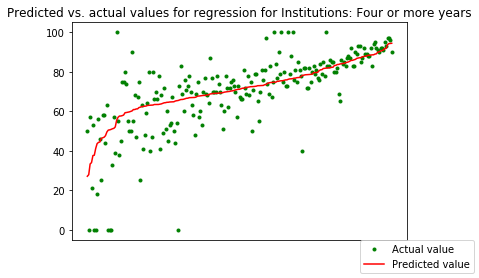

*RMSE*: 13.88

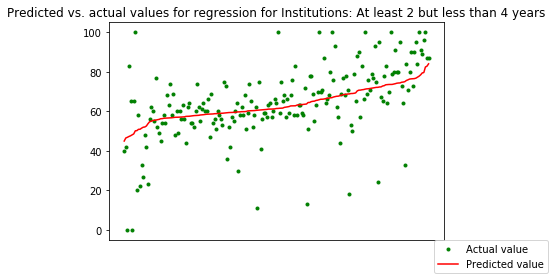

*RMSE*: 15.45

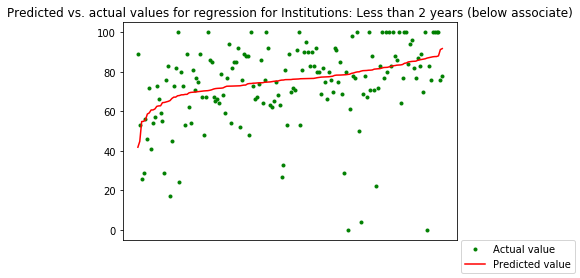

*RMSE*: 19.83

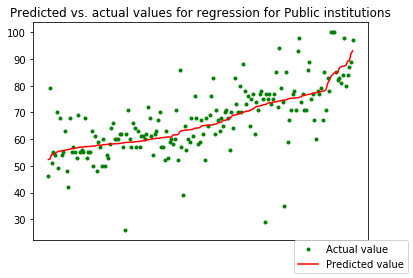

*RMSE*: 9.12

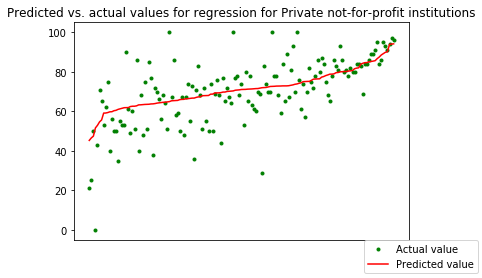

*RMSE*: 12.81

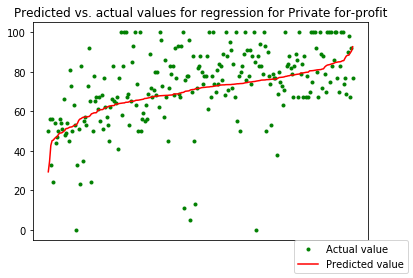

*RMSE*: 17.1

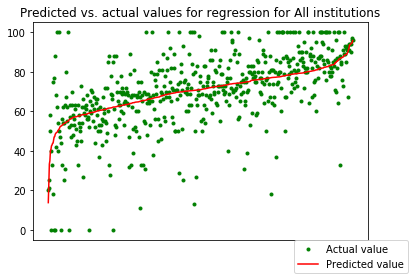

*RMSE*: 15.21

In [31]:
for fittedmodel in fittedmodels:
    results.loc[:,(fittedmodel["Data slice"], slice(None))]
    predictions = pd.DataFrame({"Predicted value": fittedmodel["Forest"] \
                                .predict(fittedmodel["Testing data"].drop(columns = responsevar)),
                                "Actual value": fittedmodel["Testing data"][responsevar]})
    predictions = predictions.sort_values(by="Predicted value").reset_index().drop(columns = "index")
    plt.axes(title = "Predicted vs. actual values for regression for " + fittedmodel["Data slice"])
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.plot(predictions["Actual value"], 'g.') 
    plt.plot(predictions["Predicted value"], 'r-')
    plt.figlegend(loc="lower right")
    plt.show()
    rmse = np.sqrt(mean_squared_error(predictions["Actual value"], predictions["Predicted value"]))
    display(Markdown("*RMSE*: " + str(round(float(rmse), 2))))

Scikit-learn has a partial dependence plot function in development: however, it's currently only in
operation for one regressor (Gradient Boosting). It's perfectly operational for the others, but an update to make it available to Random Forest, Extra Trees et al. has not yet been
merged into the main codebase. For the purposes of getting this project in before deadline, I am temporarily taking code from the pull request here 
https://github.com/scikit-learn/scikit-learn/pull/12599/files#diff-3ad63f0c81cd8eec5ca166edb911116d

This brute forces the predictions for a particular variable across a fitted model, takes the mean, and then plots the results of this. When scikit-learn reaches 0.21dev0 and the pull request is merged, I will update this code.

Import the code from my current folder; then go through each of the six top features and graphically show what effect each has on the response variable.

## Institutions: Four or more years

### R^2 score: 0.541

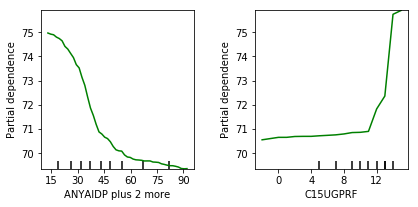

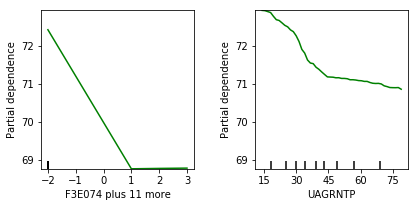

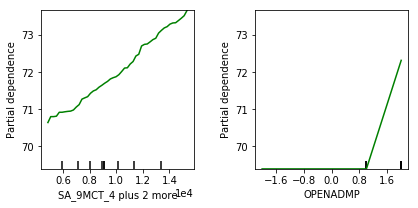

## Institutions: At least 2 but less than 4 years

### R^2 score: 0.3061

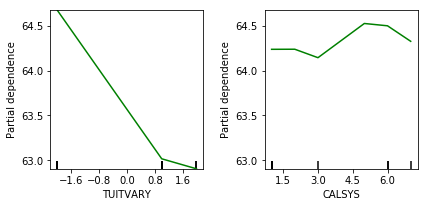

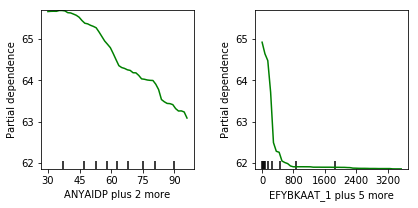

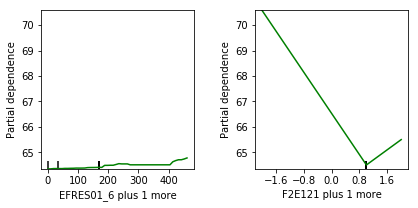

## Institutions: Less than 2 years (below associate)

### R^2 score: 0.0947

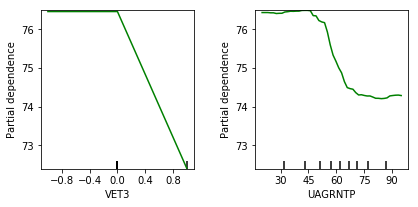

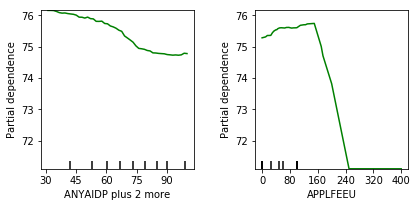

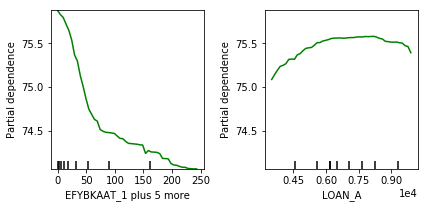

## Public institutions

### R^2 score: 0.5065

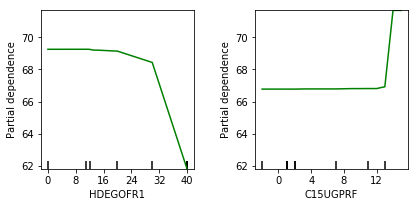

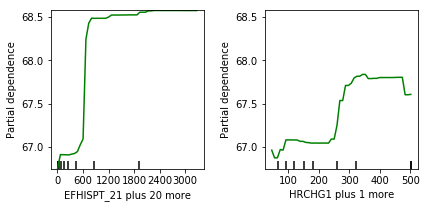

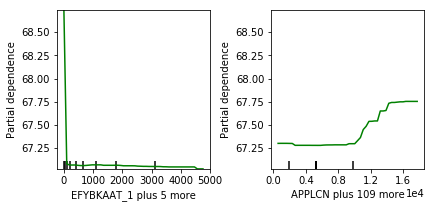

## Private not-for-profit institutions

### R^2 score: 0.44

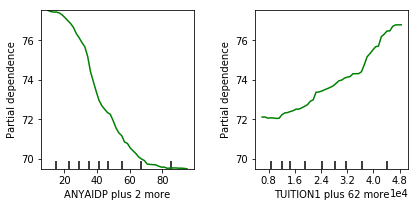

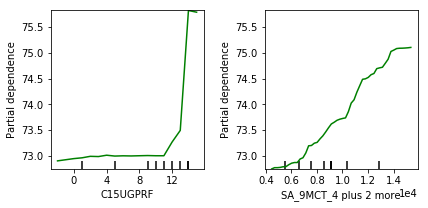

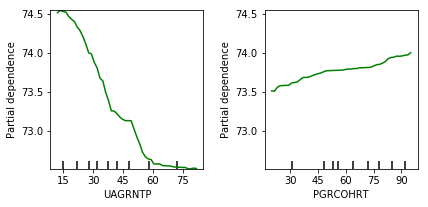

## Private for-profit

### R^2 score: 0.2325

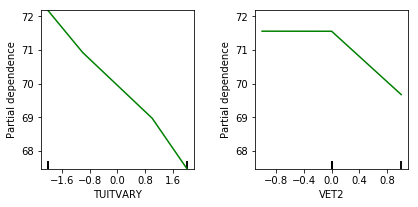

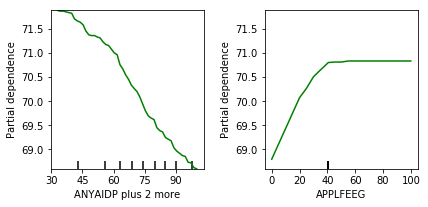

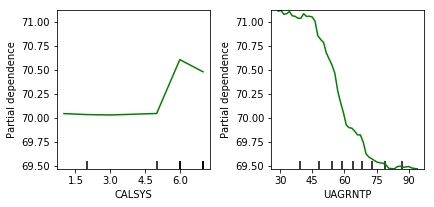

## All institutions

### R^2 score: 0.3564

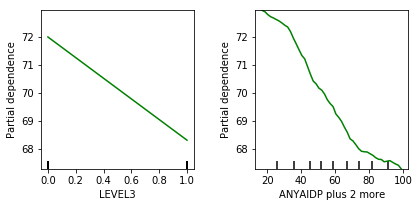

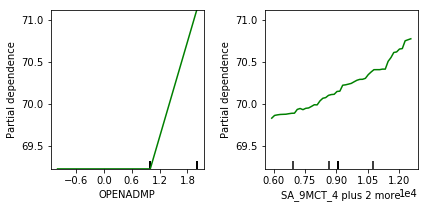

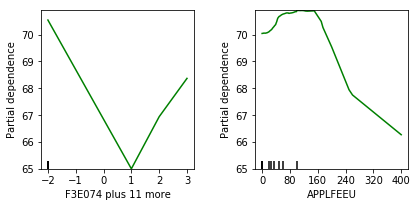

In [27]:
import partial_dependence as ptl_dpd

for fittedmodel in fittedmodels:
    display(Markdown("## "+fittedmodel["Data slice"]))
    display(Markdown("### R^2 score: "+str(round(fittedmodel["R^2"],4))))
    importance = calculate_importance(fittedmodel)
    fig, axs = ptl_dpd.plot_partial_dependence(fittedmodel["Forest"], 
                                    fittedmodel["Training data"].drop(columns = responsevar), 
                                    importance[0:2].index, feature_names=importance[0:2]["Attribute"],
                                                n_jobs=-1, grid_resolution=50)
    plt.show()
    fig, axs = ptl_dpd.plot_partial_dependence(fittedmodel["Forest"], 
                                    fittedmodel["Training data"].drop(columns = responsevar), 
                                    importance[2:4].index, feature_names=importance[2:4]["Attribute"],
                                                n_jobs=-1, grid_resolution=50)
    plt.show()
    fig, axs = ptl_dpd.plot_partial_dependence(fittedmodel["Forest"], 
                                    fittedmodel["Training data"].drop(columns = responsevar), 
                                    importance[4:6].index, feature_names=importance[4:6]["Attribute"],
                                                n_jobs=-1, grid_resolution=50)
    plt.show()

This now brings up a few questions that we can answer with, yep, more partial dependence plots.

## Institutions: Four more years 
 ### Does the amount of aid vs the number getting it delivered affect retention?

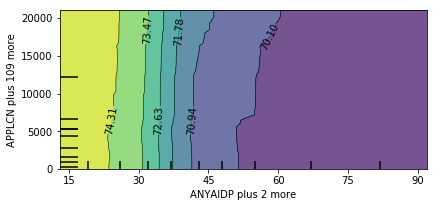

In [28]:
display(Markdown("## Institutions: Four or more years \n ### Does the amount of aid vs the number getting it delivered affect retention?"))

# ANYAID = any aid
# UAGRNTT = total amount awarded in grants

to_plot = [corrsearch(x) for x in ["ANYAIDP", "UAGRNTT"]]

# choose the first model

fittedmodel = fittedmodels[0]
importance = calculate_importance(fittedmodel)
importance = importance.loc[importance["Attribute"].isin(to_plot)]

fig, axs = ptl_dpd.plot_partial_dependence(fittedmodel["Forest"], 
                                    fittedmodel["Training data"].drop(columns = responsevar), 
                                    [(importance.index[0], importance.index[1])], 
                                    feature_names=importance["Attribute"],
                                    n_jobs=-1, grid_resolution=50)
plt.show()

## All institutions 
 ### Does the amount of aid vs the number getting it delivered affect retention?

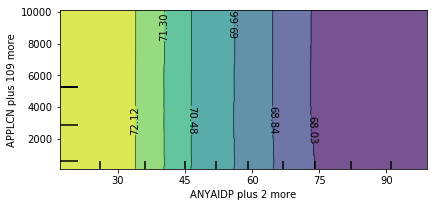

In [30]:
display(Markdown("## All institutions \n ### Does the amount of aid vs the number getting it delivered affect retention?"))

# ANYAID = any aid
# UAGRNTT = total amount awarded in grants

to_plot = [corrsearch(x) for x in ["ANYAIDP", "UAGRNTT"]]

# choose the final model

fittedmodel = fittedmodels[6]
importance = calculate_importance(fittedmodel)
importance = importance.loc[importance["Attribute"].isin(to_plot)]

fig, axs = ptl_dpd.plot_partial_dependence(fittedmodel["Forest"], 
                                    fittedmodel["Training data"].drop(columns = responsevar), 
                                    [(importance.index[0], importance.index[1])], 
                                    feature_names=importance["Attribute"],
                                    n_jobs=-1, grid_resolution=50)
plt.show()


~~ Quin Parker

Note: Help was provided by *stackoverflow.com* and *datasciencerosettastone.com*